C:\Users\avin\AppData\Local\Continuum\Anaconda3\envs\avinpy35\lib\site-packages\matplotlib\colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


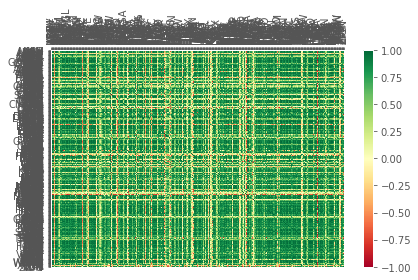

In [13]:
import bs4 as bs
import datetime as dt
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pandas_datareader.data as web
import pickle
import requests

style.use('ggplot')

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

#save_sp500_tickers()


def get_data_from_yahoo(reload_sp500=False):
    
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle","rb") as f:
            tickers = pickle.load(f)
    
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')

    start = dt.datetime(2000, 1, 1)
    end = dt.datetime(2016, 12, 31)
    
    for ticker in tickers:
        # just in case your connection breaks, we'd like to save our progress!
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            try:
                df = web.DataReader(ticker, "yahoo", start, end)
                df.to_csv('stock_dfs/{}.csv'.format(ticker))
            except:
                  print("still not working ! bad ticker need to investiagte" + ticker)
        else:
            print('Already have {}'.format(ticker))

#get_data_from_yahoo()

def compile_data():
    with open("sp500tickers.pickle","rb") as f:
        tickers = pickle.load(f)

    main_df = pd.DataFrame()
    
    for count,ticker in enumerate(tickers):
        try:
            df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
            df.set_index('Date', inplace=True)

            df.rename(columns={'Adj Close':ticker}, inplace=True)
            df.drop(['Open','High','Low','Close','Volume'],1,inplace=True)

            if main_df.empty:
                main_df = df
            else:
                main_df = main_df.join(df, how='outer')

            if count % 10 == 0:
                print(count)
        except:
            print("misisng ticker data" + ticker)
    print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')

def visualize_data():
    df = pd.read_csv('sp500_joined_closes.csv')
    df_corr = df.corr()
    df_corr.to_csv('sp500corr.csv')
    
    data1 = df_corr.values
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)

    heatmap1 = ax1.pcolor(data1, cmap=plt.cm.RdYlGn)
    fig1.colorbar(heatmap1)
    ax1.set_xticks(np.arange(data1.shape[1]) + 0.5, minor=False)
    ax1.set_yticks(np.arange(data1.shape[0]) + 0.5, minor=False)
    ax1.invert_yaxis()
    ax1.xaxis.tick_top()
    column_labels = df_corr.columns
    row_labels = df_corr.index
    ax1.set_xticklabels(column_labels)
    ax1.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap1.set_clim(-1,1)
    plt.tight_layout()
    plt.show()
    
visualize_data()
